# Knowledge Distillation for SALAD's Learning Rate Optimization 

This notebook evaluates the knowledge distillation method used to
optimize SALAD's learning rate at run time.

To estimate the SINR, SALAD uses a "student" iterative estimator based on gradient-descent
on a binary cross-entropy loss function of the previous ACK/NACK observations.

SALAD's "student" learning rate is optimized by comparing the student's
estimation against those of a more powerful estimator, which is not iterative
and minimizes the cross-entropy loss of all ACK/NACK observations in a batch.

For technical details, please refer to [[1]](#salad-ref).


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('../')  # to access all relevant repo files

# LaTeX-style fonts for plots
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

from algos import SALAD
from utils import StudentSINREstimator, TeacherSINREstimator, \
    run_la, rescale, get_bler_sigmoid_params
from config import BLER_FILENAME

# Fix random seed for reproducibility
np.random.seed(11)

## Simulation parameters

In [78]:
# Long-term BLER target (= average portion of NACKs)
bler_target = 0.1

# MCS table index
table_index = 2

# For simplicity, code block size is fixed throughout the simulation
cbs = 2000

# N. slots to simulate
n_slots = 4000

### BLER table

Load BLER tables with corresponding sigmoid approximations

In [79]:
# Read BLER table
df = pd.read_csv('../' + BLER_FILENAME)

# Extract sigmoid parameters to approximate BLER tables
bler_sigmoid_params = get_bler_sigmoid_params(df, cbs, table_index)

## SINR time evolution

The SINR evolves according to a predefined sinusoid with varying frequency. 

This will allow us to illustrate how well SALAD's learning rate adapts to the SINR variation speed.

In [80]:
# Lower / upper bounds of the SINR
sinr_bounds = [10, 20]

# SINR sinusoidal periods
# The SINR evolves with different frequencies
sinr_period_vec = [500, 100, 1000, 150]

n_slots = int(n_slots // len(sinr_period_vec) * len(sinr_period_vec))

Generate the SINR time evoluton

In [81]:
# Slots
t = np.arange(n_slots)

# Generate SINR with varying frequency
sinr_true = np.zeros(n_slots)
for ii, period in enumerate(sinr_period_vec):
    sinr_true[ii*n_slots//len(sinr_period_vec):(ii+1)*n_slots//len(sinr_period_vec)] = \
        np.sin(2*np.pi*t[ii*n_slots//len(sinr_period_vec):(ii+1)*n_slots//len(sinr_period_vec)]/period)

# Rescale the SINR to the given bounds
sinr_true = rescale(sinr_true, sinr_bounds)

Plot the SINR evolution over time

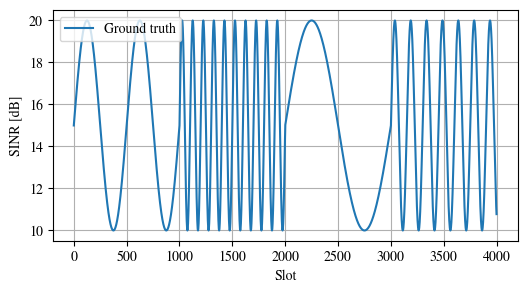

In [82]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(sinr_true, label='Ground truth')
ax.set_xlabel('Slot')
ax.set_ylabel('SINR [dB]')
ax.grid()
ax.legend(loc='upper left')
plt.show()

## SALAD

Set SALAD's configuration parameters

In [83]:
# Bias score ratio threshold for MCS probing
rho_calibration = .25

# N. slots over which the bias score is computed
score_window = 15

# Prob(probing a high MCS index), if the bias score > rho_calibration
prob_probe = .15

# Integral gain
k_e = .02

# Initial SINR estimate
sinr_est_init = 15

### Teacher SINR estimator 

The teacher SINR estimator estimates the SINR over the last
`opt_over_last_n_samples` by minimizing the cross-entropy loss between the
ACK/NACKs and the corresponding BLER, by batch gradient descent. 

It can also smooths out SINR estimation via a regulizer term with coefficient `beta_regularization`.

In [ ]:
# N. last samples over which KD is performed
opt_over_last_n_samples = 400

# Smoothness regularizer
beta_regularization = 0.

# Learning rate for teacher's gradient descent
learning_rate_teacher = .01

# N. teacher's gradient descent iterations
n_iter_gd = 500

In [85]:
# Initialize the teacher's SINR estimator
teacher_estimator = TeacherSINREstimator(
    bler_sigmoid_params,
    opt_over_last_n_samples=opt_over_last_n_samples,
    n_iter_gd=n_iter_gd,
    learning_rate=learning_rate_teacher,
    beta_regularization=beta_regularization,
    cross_validation=True)

### Student SINR estimator

SALAD's "student" SINR predictor performs a simple iterative update of the
previous SINR via gradient descent of the cross-entropy loss, with a certain
learning rate.

Every `knowledge_distillation_period` slots, knowledge distillation is performed
to optimize the student's learning rate among a list of candidate values `candidate_learning_rates`.

In [ ]:
# Every how many slots knowledge distillation (KD) is performed
knowledge_distillation_period = 200

# Initial learning rate
learning_rate_init = .3

# Candidate student's learning rates for KD
candidate_learning_rates = np.arange(.1, 2, .1)

In [87]:
# Initialize the student's SINR predictor
sinr_estimator = StudentSINREstimator(
    bler_sigmoid_params,
    sinr_init=sinr_est_init,
    learning_rate_init=learning_rate_init,
    teacher_estimator=teacher_estimator,
    knowledge_distillation_period=knowledge_distillation_period,
    candidate_learning_rates=candidate_learning_rates)

### Run SALAD

Simulate SALAD on the predetermined SINR time evolution

In [88]:
# Initialize SALAD
salad = SALAD(bler_target,
              bler_sigmoid_params,
              sinr_estimator,
              rho_calibration=rho_calibration,
              prob_probe=prob_probe,
              k_e=k_e,
              score_window=score_window)

# Run SALAD with knowledge distillation
is_nack_hist_salad, salad, mcs_hist_salad = \
    run_la(salad, sinr_true, bler_sigmoid_params)

## Plot the results

Show how well the learning rate adapts to the SINR variation speed

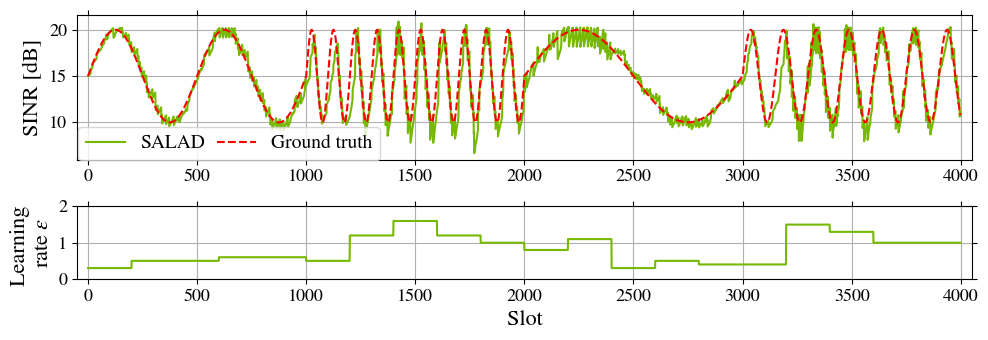

In [89]:
# Font size
tick_fs = 13
ylabel_fs = 16
xlabel_fs = 16
legend_fs = 14

fig, axs = plt.subplots(2, 1,
                        height_ratios=[1, .5],
                        figsize=(10, 3.5),
                        sharex='col')

# Plot inferred SINR vs ground truth
axs[0].plot(salad.sinr_estimator.sinr_hist, '-',
            color='#76B900', label='SALAD')
axs[0].plot(sinr_true, '--r', label='Ground truth')

axs[0].legend(loc='lower left', columnspacing=0.6,
              fontsize=legend_fs, ncol=2,
              bbox_to_anchor=(-0.01, -.07))
axs[0].grid()
axs[0].set_ylabel('SINR [dB]', fontsize=ylabel_fs)
axs[0].set_xlim(-50, n_slots+50)

# Plot optimized student's learning rate over time
axs[1].plot(np.repeat(salad.sinr_estimator.learning_rate_hist[:-1],
                      knowledge_distillation_period), '-', color='#76B900')
axs[1].grid()
axs[1].set_xlabel('Slot', fontsize=xlabel_fs)
axs[1].set_ylabel('Learning \n' + r'rate $\varepsilon$',
                  fontsize=ylabel_fs)
axs[1].set_yticks([0, 1, 2])

axs[1].set_ylim(0, 2)

# Show x and y ticks
for ax in axs:  # fig.axes:
    ax.tick_params(axis='x',
                   which='both',
                   bottom=True,
                   top=True,
                   labelbottom=True)
    ax.tick_params(axis='y',
                   which='both',
                   left=True,
                   right=True,
                   labelleft=True)
    ax.tick_params(axis='both', labelsize=tick_fs)
fig.tight_layout()

plt.show()

The student's learning rate $\varepsilon$ adapts to the frequency of the unknown SINR,
allowing SALAD to closely track the ground truth. As the frequency increases,
$\varepsilon$ increases accordingly to follow faster SINR variations. Conversely, as the
frequency decreases, $\varepsilon$ is reduced to prevent excessive fluctuations.

### References

<a id="salad-ref"></a>
**[1]** R. Wiesmayr, L. Maggi, S. Cammerer, F. Ait Aoudia, J. Hoydis, A. Keller,
"SALAD: Self-Adaptative Link Adaptation", arXiv, 2025